In [ ]:
# Let’s say you are trying to use a noisy, blurred, low resolution, heavily quantized video feed to estimate the x,y position of a ball.  The primary objective is to estimate the position of the ball as accurately as possible, and as quickly as possible!

# Here is what we know:
#     The field of view of the camera is dark (pixel intensity 0), except for a single ball with uniform brightness (pixel intensity 7) 
#     The ball is exactly 10 pixels in diameter, and has perfectly elastic collisions will the four “walls” bounding the square field of view of the camera
#     There are no external forces acting on the ball (no gravity, no air resistance)
#     The camera's CCD has 101x101 pixels, each with 3-bit intensity resolution [0,7] (greyscale)
#     The camera’s CCD is noisy. Each pixel has noise ~unif(0,5).  This noise is uncorrelated from pixel to pixel, and frame to frame.
#     The ball’s initial position is pixel [0,0] but its initial velocity vector is unknown. The maximum velocity is 7.5 pixels per frame.

# Here are the deliverables:
#     Python simulation of this system. Please comment your code thoroughly, as it will be reviewed in detail.  If you use any open source code, please include citations.
#     A dozen slides containing:
#         Block diagram depicting your simulation structure
#         Why you chose the algorithms you did (what else did you consider?)
#         Plot of estimation accuracy vs frame count (does it converge? Any residual “steady state” error in the long run? Does performance depend on initial condition?)
#         Some analytical justification for the simulation results you are seeing (did simulation agree with analytical? If so, why? If not, why not?)
#         Estimate of total processing resources required to run your system in real time (MAC operations/frame)
#         What would you do differently in your approach if you had more time?
#         What did you find most challenging about this project

In [2]:
# Imports (Run once)
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pdb # For debugging
import cairo 
import math
import cv2
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral)
from skimage import feature

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This function adds uniformly distributed noise to each frame and quantizes it
def add_noise(x, lim_low=0.0, lim_high=6.0, bitdepth=3,rs=np.random.RandomState(seed=42)):
    
    b = rs.uniform(low=lim_low, high=lim_high, size=x.shape) + x # Add uniform noise
#     print(b)
    adu = b.astype(np.int) # Convert to discrete numbers
#     print(adu)
    max_adu = np.int(2**bitdepth - 1)
    adu[adu>max_adu] = max_adu # Models pixel saturation
#     print(adu)
    
    return adu

In [68]:
num_pixels = 101
half_window = (num_pixels-1)/2
vel = [random.uniform(-7.5,7.5) for i in range(2)] # generate a vector with a random x and y velocity
pos = [half_window,half_window] # initial position
radius = 5
num_frames = 100
z = np.linspace(0,num_frames, num=num_frames)

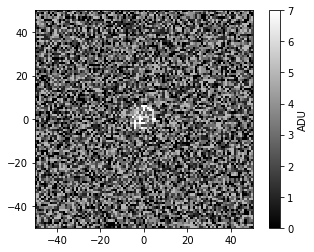

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=1)
base_img = np.zeros((num_pixels, num_pixels,4), dtype=np.uint8) # Should be black, 101x101 pixel
surface = cairo.ImageSurface.create_for_data(
    base_img, cairo.FORMAT_ARGB32, num_pixels, num_pixels)
cr = cairo.Context(surface)
cr.set_source_rgb(1.0,1.0,1.0)
cr.paint()
cr.arc(half_window, half_window, radius, 0, 2*math.pi)
cr.set_source_rgb(0.0,0.0,0.0)
cr.stroke_preserve()
cr.fill()
circ_img = base_img[:,:,0]
circ_img = (1 - (circ_img/circ_img.max())) * 2.0 # intensity of circle
adu = add_noise(circ_img)
img = ax.imshow(adu,cmap='gray')
img.set_extent([-half_window, half_window, -half_window, half_window])
cb  = plt.colorbar(img)
cb.set_label('ADU')

/home/anirudh/.local/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


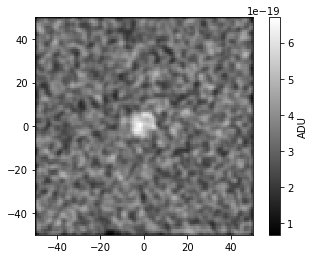

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=1)
denoised = denoise_bilateral(adu, multichannel=False)
img2 = ax.imshow(denoised, cmap='gray')
img2.set_extent([-half_window, half_window, -half_window, half_window])
cb  = plt.colorbar(img2)
cb.set_label('ADU')

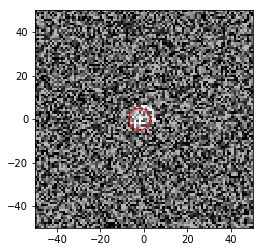

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=1)
(min_val, max_val, min_loc, max_loc) = cv2.minMaxLoc(denoised)
max_location = (max_loc[0]-half_window, max_loc[1]-half_window)
adu_cp = adu.copy()
circle1 = plt.Circle(max_location,radius,color='r', fill=False)
img3 = ax.imshow(adu_cp, cmap='gray')
ax.add_artist(circle1)
img3.set_extent([-half_window, half_window, -half_window, half_window])

In [ ]:
def __init__():
    img.set_data(np.zeros((num_pixels,num_pixels)))
    return img

In [ ]:
def animate(frame):
    